# H$\alpha$ FILTER


**OBSERVATIONS**

g:  3x120s\
r:  3x120s\
i:  3x120s\
Ha: 1x900s + 4x300s\
Hb: 4x1200s

**TOBI**

- Sensor Type: CCD - KAF-16200 APS cut (35mm diagonal)
- Horizontal Resolution: 4499 pixels
- Vertical Resolution: 3599 pixels
- Pixel Size: 6 µm x 6 µm
- ADC: 16 bit
- Readout Noise: 9e- typical value
- Gain Factor: 0.6e-/ ADU
- Full Well: ~40,000e-
- Dark Current: >0.25 electrons/second at 0°C
- Maximum Exposure Length: Unlimited
- Minimum Exposure Length: 200 ms
- Cooling: Thermoelectric set point with max ΔT=>-50°C
- 6 µm pixel means 0.44”/pix

**IMAGE REDUCTION**

In real situations getting dark frames with same exposure times of object frames is impraticable. Lot of time wasted. We can repeat measures for different (short) exposure times and obtain a curve of the dark current counts vs time. 


$$\text{Final}= \left[ \text{Object Frame} - \left(\text{Dark} - \text{Bias}\right) \tfrac{\Delta t_\text{Obj}}{\Delta t_\text{Dark}} - \text{Bias} \right] {\huge/} \text{Flat normalized}$$ 

IF object frame exposure time and dark frame exposure time are equal, like in our case:

$$\text{Final}= \left[ \text{Object Frame} - \text{Dark} \right] {\huge/} \text{Flat normalized}$$ 

**Flat Frames:**

- Purpose: Flat frames correct for vignetting, dust spots, and optical imperfections in the imaging system (such as the lens or telescope).
- What they capture: Flat frames are taken by pointing the camera at a uniformly lit surface (e.g., a white sheet of paper, a clear blue sky, or a lightbox) with the same exposure time and settings as the light frames.
- Effect: These frames correct for variations in brightness across the image, such as areas where the image is darker (vignetting) or where dust spots on the lens or sensor create uneven lighting. The flat frames are used to divide the light frames to normalize the brightness.

Flats counts are much more than the object frame. This is not a deal, because in the end we have to normalize them.



In [1]:
# Open the FITS file
from astropy.io import fits

with fits.open('data/data_Ha_filter_30_10_24/IC5146_Ha_000.fit') as hdul:
    #hdul.info()                         # Display information about the FITS file contents
    print(hdul[0].header)
    exp_time = hdul[0].header['EXPTIME']
    frame_obj = hdul[0].data           # Access the primary data (assuming image is in the primary HDU)


SIMPLE  =                    T                                                  BITPIX  =                   16                                                  NAXIS   =                    2                                                  NAXIS1  =                 4499                                                  NAXIS2  =                 3599                                                  BZERO   =           32768.000000                                                BSCALE  =             1.000000                                                  DATAMIN =             0.000000                                                  DATAMAX =           65535.000000                                                INSTRUME=           'ATIK-16200: fw rev 3.52'                                   FILTER  =           'Position 1'                                                EXPTIME =           900.000                                                     DATE-OBS=           '2024-10-28T18:00:22

Common WCS-related keywords include:

    CRPIX1, CRPIX2: Reference pixel coordinates.
    CRVAL1, CRVAL2: RA and Dec of the reference pixel.
    CD1_1, CD1_2, CD2_1, CD2_2: Transformation matrix for pixel-to-world conversion.
    CDELT1, CDELT2: Pixel scale (alternative to CD matrix).
    CTYPE1, CTYPE2: Coordinate type (e.g., 'RA---TAN' and 'DEC--TAN' for tangent-plane projection).
    EQUINOX or RADESYS: Equinox or reference frame (e.g., 'J2000').
    EXPTIME: Exposure time (s)
    CCD-TEMP: Temperature of the CCD (K)

This FITS file does not contain WCS.

In [2]:
# Convert from ADU to electrons

gain_factor = 0.6

frame_obj = frame_obj * gain_factor

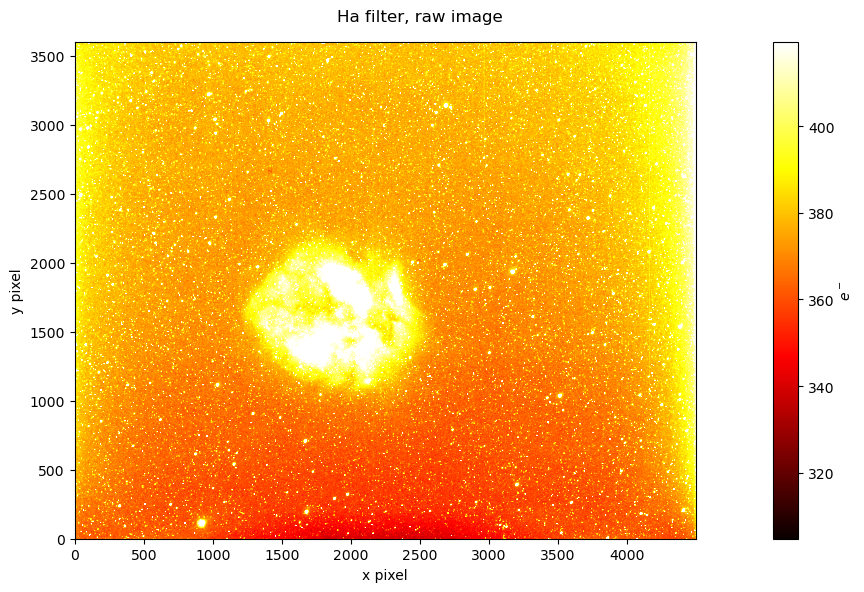

In [5]:
# Display RAW IMAGES 
import numpy as np
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(9, 6))  # ax is a single AxesSubplot when only one subplot is created
fig.suptitle("Ha filter, raw image")

# Single subplot, so no need to iterate
im = ax.imshow(frame_obj, clim=np.quantile(frame_obj[0], [0.005, 0.995]), cmap='hot', origin='lower')  
plt.colorbar(im, ax=ax, location='right', fraction=0.0375, pad=0.1, label="$e^-$")  # Attach colorbar to the single subplot
ax.set(xlabel="x pixel", ylabel="y pixel")  # Set labels for the single axis

plt.tight_layout()
plt.show()


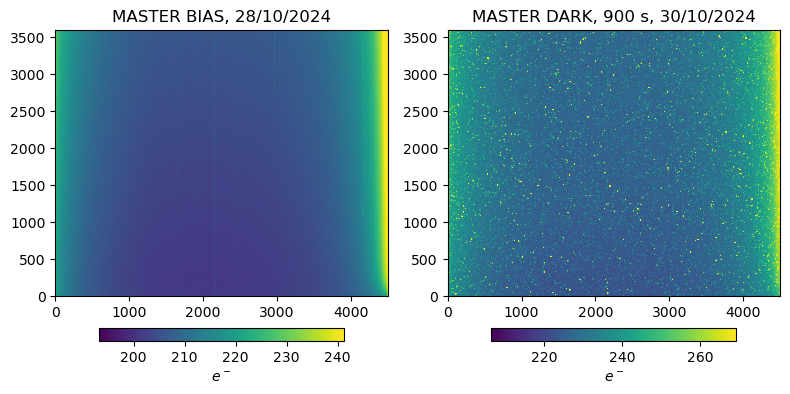

In [16]:
# MASTER BIAS and DARK

with fits.open('data/master_bias.fit') as hdul:
    #hdul.info()                # Display information about the FITS file contents
    master_bias = hdul[0].data  # Access the primary data (assuming image is in the primary HDU)

with fits.open('data/master_dark_900.fit') as hdul:
    #hdul.info()                # Display information about the FITS file contents
    master_dark = hdul[0].data  # Access the primary data (assuming image is in the primary HDU)

# Display master bias and master dark

fig, ax = plt.subplots(1,2,figsize=(8,4))

im1 = ax[0].imshow(master_bias, clim=np.quantile(master_bias, [0.01, 0.99]), cmap='viridis', origin='lower')  
plt.colorbar(im1, ax=ax[0], location='bottom', fraction=0.0375, pad=0.1, label="$e^-$")
ax[0].set_title("MASTER BIAS, 28/10/2024")

im2 = ax[1].imshow(master_dark, clim=np.quantile(master_dark, [0.01, 0.99]), cmap='viridis', origin='lower')  
plt.colorbar(im2, ax=ax[1], location='bottom', fraction=0.0375, pad=0.1, label="$e^-$") 
ax[1].set_title("MASTER DARK, 900 s, 30/10/2024")

#plt.subplots_adjust(bottom=0.15) 
plt.tight_layout()
plt.show()



In [7]:
# Path to the FITS files
file_path = [f'data/flat_Ha_30_10_24/Calib_01{str(i).zfill(1)}flat_m20_Ha_4s.fit' for i in range(0,5)]

# Open the FLAT files
flat = []

for f_p in file_path:    
    with fits.open(f_p) as hdul:
        #hdul.info()    # Display information about the FITS file contents
        flat.append(hdul[0].data)  # Access the primary data (assuming image is in the primary HDU)


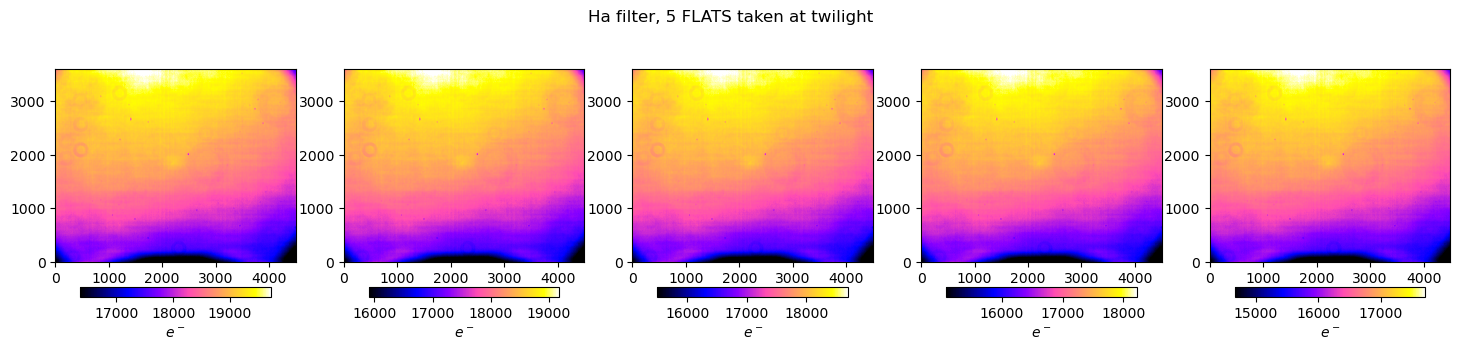

In [8]:
fig, ax = plt.subplots(1,5,figsize=(18,3.3))
fig.suptitle("Ha filter, 5 FLATS taken at twilight")

for i in range(5):

    im = ax[i].imshow(flat[i] * gain_factor, clim=np.quantile(flat[i]*gain_factor, [0.01, 0.99]), cmap='gnuplot2', origin='lower')  # Use clim to scale the image based on the 1st and 99th quantiles
    plt.colorbar(im, ax=ax[i], location='bottom', fraction=0.0375, pad=0.1, label="$e^-$")  # Make sure to use the `im` object for colorbar

plt.show()

In [8]:
### normalize each flat to it's median value

for i in range(len(flat)):
    flat[i] = flat[i]/np.median(flat[i]) 

# stack and take the mean as the master flat 

flat_stack = np.stack(flat, axis=0)  
flat_mean = np.mean(flat_stack, axis=0)   

del flat, flat_stack 


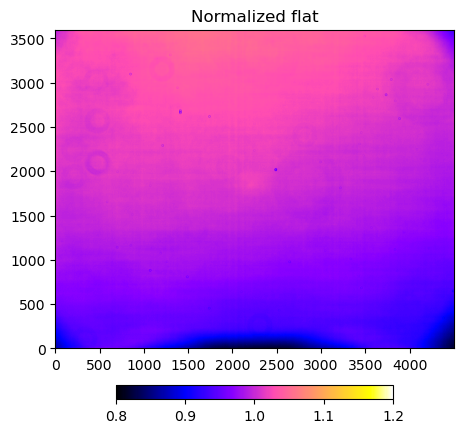

In [16]:
im = plt.imshow(flat_mean, cmap='gnuplot2', clim=[0.8,1.2], origin='lower')  
plt.colorbar(im, location='bottom', fraction=0.0375, pad=0.1)  
plt.title("Normalized flat")
plt.show()

In [9]:
frame_sky = (frame_obj - master_dark)/flat_mean

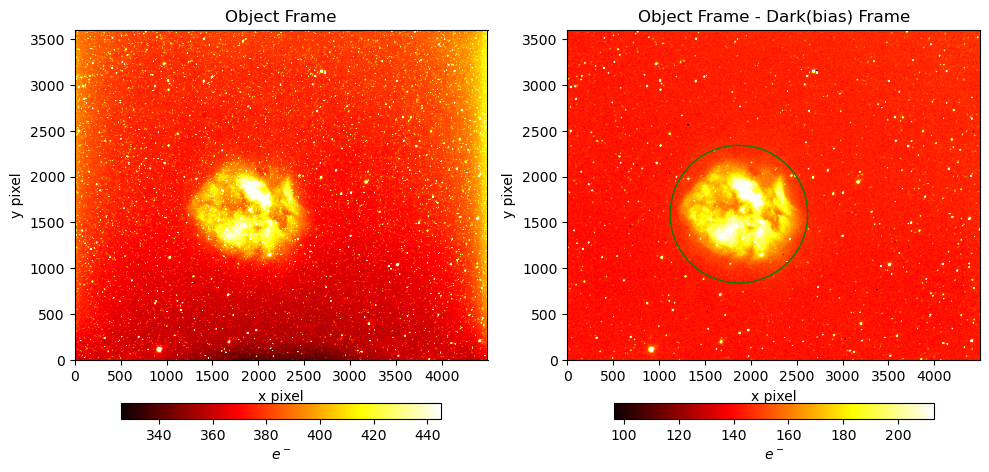

In [10]:
# Display science IMAGES 

fig, ax = plt.subplots(1,2,figsize=(10,5))  

im0 = ax[0].imshow(frame_obj, clim=np.quantile(frame_obj, [0.01, 0.99]), cmap='hot', origin='lower')  
plt.colorbar(im0, ax=ax[0], location='bottom', fraction=0.0375, pad=0.1, label="$e^-$")  
ax[0].set(xlabel="x pixel", ylabel="y pixel")  
ax[0].set_title("Object Frame")


im1 = ax[1].imshow(frame_sky, clim=np.quantile(frame_sky, [0.01, 0.99]), cmap='hot', origin='lower')  
plt.colorbar(im1, ax=ax[1], location='bottom', fraction=0.0375, pad=0.1, label="$e^-$")  
ax[1].set(xlabel="x pixel", ylabel="y pixel")  
ax[1].set_title("Object Frame - Dark(bias) Frame")

from matplotlib.patches import Circle
radius = 750
center = (1870,1590)
ax[1].add_patch(Circle(center, radius, color='green', fill=False))

plt.tight_layout()
plt.show()


**Sky subtraction**

Photutils.background: https://photutils.readthedocs.io/en/stable/api/photutils.background.Background2D.html#photutils.background.Background2D

- It first identifies the regions of the image that are not contaminated by sources (stars, galaxies, etc.), typically by using segmentation or thresholding techniques.
- It then estimates the background level in those regions, using a selected statistical method (mean, median, etc.).
- The background model is smoothed over the image, so you get a smooth map of the background which you can subtract from your original image.

MedianBackground: computes a median background in your image in a specified region. This is particularly useful when you have an image with significant outliers (e.g., bright stars or galaxies) that could skew the average value.

- It divides the image into small regions or blocks (sub-arrays).
- For each block, it computes the median pixel value and uses that as the estimate for the background in that region.

BkgZoomInterpolator: used to interpolate the background model computed from Background2D. Sometimes, the background estimate might not be smooth enough or could have regions with missing data. The BkgZoomInterpolator allows you to interpolate the background estimation in a finer grid to get a smooth and continuous background map that can be subtracted from the image.

- After computing the background using a method like median, the interpolation method will use zooming (resampling) techniques to generate a more refined background model across the image.
- It can be useful if you need a higher resolution or smoother background model for more accurate subtraction.

In [11]:
# Sky subtraction

from photutils.background import (Background2D, MedianBackground, BkgZoomInterpolator)  
from astropy import stats as astrostats

Y, X = np.ogrid[:3599, :4499]
radius = 750
center = (1870,1590)
mask_circ = np.sqrt((X - center[0])**2 + (Y-center[1])**2) <= radius


box_size = (50,50) 
filter_size = (3,3)
exclude_percentile = 30
    
bkg = Background2D(frame_sky,
                mask=mask_circ,                             # 'mask' defines which pixels to exclude from the background estimation.
                box_size=box_size,                          # 'box_size' is the size (in pixels) of the box used to estimate the background.
                sigma_clip=astrostats.SigmaClip(sigma=3.),  # 'sigma_clip' is the method to use for robust averaging within the grid cells.
                filter_size=filter_size,                    # 'filter_size' is how many cells to "averaged" before doing the interpolation. This can also be a rectangle -- e.g. (3,4) -- if desired.
                exclude_percentile=exclude_percentile,      # 'exclude_percentile'. If a mesh has more than this percent of its pixels masked then it will be excluded from the low-resolution map.
                bkg_estimator=MedianBackground(),           # 'bkg_estimator' is the method to use for averaging the values in the cells.
                interpolator=BkgZoomInterpolator(order=3))  # 'interpolator' is the method to use to interpolate the background (bicubic spline in this case).

frame_sky_subtracted = frame_sky - bkg.background


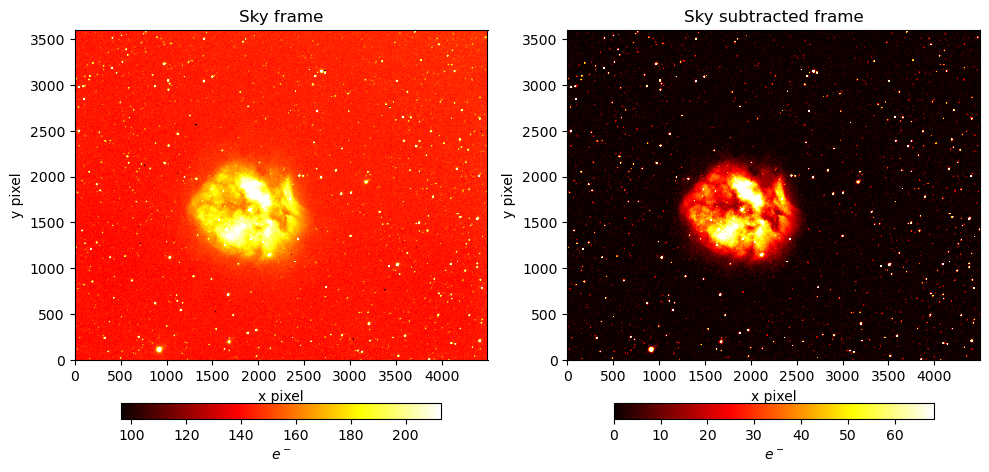

In [13]:
# Display sky subtracted IMAGE 

fig, ax = plt.subplots(1,2,figsize=(10,5))  

im0 = ax[0].imshow(frame_sky, clim=np.quantile(frame_sky, [0.01, 0.99]), cmap='hot', origin='lower')  
plt.colorbar(im0, ax=ax[0], location='bottom', fraction=0.0375, pad=0.1, label="$e^-$")  
ax[0].set(xlabel="x pixel", ylabel="y pixel")  
ax[0].set_title("Sky frame")


im1 = ax[1].imshow(frame_sky_subtracted, clim=[0,np.quantile(frame_sky_subtracted, 0.99)], cmap='hot', origin='lower')  
plt.colorbar(im1, ax=ax[1], location='bottom', fraction=0.0375, pad=0.1, label="$e^-$")  
ax[1].set(xlabel="x pixel", ylabel="y pixel")  
ax[1].set_title("Sky subtracted frame")

plt.tight_layout()
plt.show()

In [17]:
hdu = fits.PrimaryHDU(frame_sky_subtracted)
hdu.writeto('data/cleaned_not_calibrated/Ha_filter_science.fit', overwrite=True)